In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs6353/assignments/assignment2/'
FOLDERNAME = 'CS6353/Assignments/assignment2/assignment2/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs6353/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Install requirements from colab_requirements.txt
# TODO: Please change your path below to the colab_requirements.txt file
! python -m pip install -r /content/drive/My\ Drive/$FOLDERNAME/colab_requirements.txt

Mounted at /content/drive
/content/drive/My Drive/CS6353/Assignments/assignment2/assignment2/cs6353/datasets
--2024-09-30 00:42:53--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  51.8MB/s    in 3.3s    

2024-09-30 00:42:57 (49.8 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content/drive/My Drive/CS6353/Assignments/assignment2/assignment2
     ━━━━━━━

# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://utah.instructure.com/courses/919972/assignments/12590082) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:

from __future__ import print_function
import random
import numpy as np
from cs6353.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs6353.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(cifar10_dir='cs6353/datasets/cifar-10-batches-py', num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

################################################################################
# TODO: Change the path of the CIFAR-10 data directory correctly to            #
# the correct location                                                         #
# Default path is set to cs6353/datasets/cifar-10-batches-py'                 #
################################################################################
cifar10_dir='cs6353/datasets/cifar-10-batches-py'
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir)

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs6353.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [12]:
# Use the validation set to tune the learning rate and regularization strength

from cs6353.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-7, 1e-5, 1e-4, 1e-3, 2e-7]
regularization_strengths = [1, 1e-1, 2e-1, 5e-1, 1e-2, 5e3]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifier in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:

        svm = LinearSVM()

        svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=True)

        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)

        train_results = y_train_pred == y_train
        y_train_accuracy = np.mean(train_results)

        val_results = y_val_pred == y_val
        y_val_accuracy = np.mean(val_results)

        results[(lr, reg)] = (y_train_accuracy, y_val_accuracy)

        if y_val_accuracy > best_val:
            best_val = y_val_accuracy
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 9.013532
iteration 100 / 1500: loss 9.005905
iteration 200 / 1500: loss 8.999067
iteration 300 / 1500: loss 9.010873
iteration 400 / 1500: loss 9.012125
iteration 500 / 1500: loss 9.006480
iteration 600 / 1500: loss 8.998394
iteration 700 / 1500: loss 8.996802
iteration 800 / 1500: loss 9.006092
iteration 900 / 1500: loss 9.003871
iteration 1000 / 1500: loss 9.006651
iteration 1100 / 1500: loss 8.996429
iteration 1200 / 1500: loss 8.993661
iteration 1300 / 1500: loss 8.987182
iteration 1400 / 1500: loss 8.996445
iteration 0 / 1500: loss 9.000013
iteration 100 / 1500: loss 8.995990
iteration 200 / 1500: loss 8.995294
iteration 300 / 1500: loss 9.006803
iteration 400 / 1500: loss 8.995009
iteration 500 / 1500: loss 8.987107
iteration 600 / 1500: loss 8.997460
iteration 700 / 1500: loss 8.988426
iteration 800 / 1500: loss 8.985681
iteration 900 / 1500: loss 8.985636
iteration 1000 / 1500: loss 8.997433
iteration 1100 / 1500: loss 8.983115
iteration 1200 / 1500: lo

/content/drive/MyDrive/CS6353/Assignments/assignment2/assignment2/cs6353/classifiers/linear_svm.py:100: RuntimeWarning: overflow encountered in scalar multiply
  loss += reg * np.sum(W * W)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  
/content/drive/MyDrive/CS6353/Assignments/assignment2/assignment2/cs6353/classifiers/linear_svm.py:100: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)
/content/drive/MyDrive/CS6353/Assignments/assignment2/assignment2/cs6353/classifiers/linear_svm.py:125: RuntimeWarning: overflow encountered in multiply
  dW += 2 * reg * W
/content/drive/MyDrive/CS6353/Assignments/assignment2/assignment2/cs6353/classifiers/linear_classifier.py:70: RuntimeWarning: invalid value encountered in subtract
  self.W -= learning_rate * grad


iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 8.979867
iteration 100 / 1500: loss 8.996251
iteration 200 / 1500: loss 9.001369
iteration 300 / 1500: loss 8.980656
iteration 400 / 1500: loss 8.981561
iteration 500 / 1500: loss 8.991502
iteration 600 / 1500: loss 8.959770
iteration 700 / 1500: loss 8.987205
iteration 800 / 1500: loss 8.983566
iteration 900 / 1500: loss 8.986715
iteration 1000 / 1500: loss 8.981800
iteration 1100 / 1500: loss 8.968632
iteration 1200 / 1500: loss 8.956905
iteration 1300 / 1500: loss 8.979529
iteration 1400 / 1500: loss 8.977704
iteration 0 / 1500: loss 8.998422
iteration 100 / 1500: loss 8.985798
iteration 200 / 1500: loss 8.977414
iteration 300 / 1500: loss 8.982007


In [13]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.48


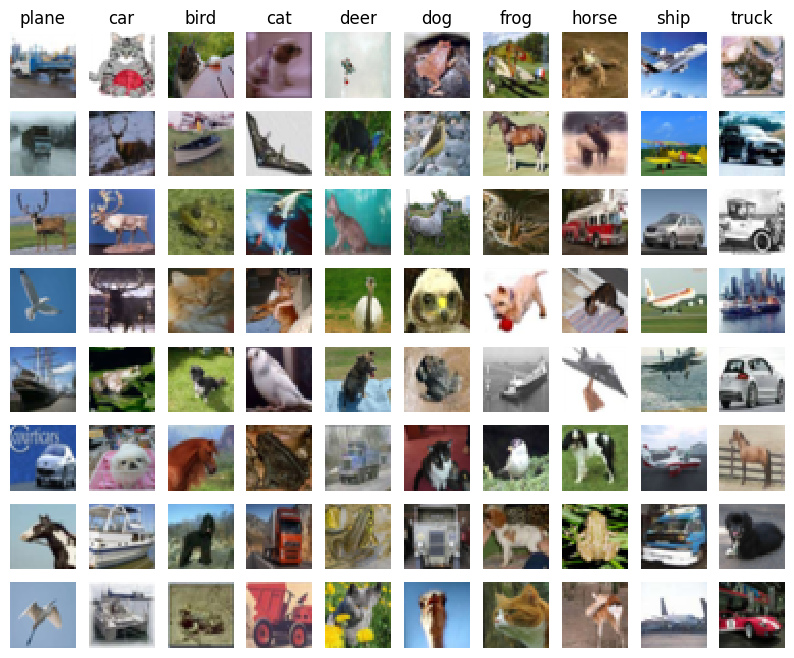

In [14]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

Yes, some of the misclassifications make sense:

1. Birds in flight are misclassified as planes, due the background colour of the image and the similarity in the images. Also images having significant blue background are misclassified as planes due to the similarity in the background colour.

2. Cat, deer, dog, frog and horse images are also misclassified due to common features like legs, eyes, shape of their body, similarities in fur textures, etc.

3. Vehicles like trucks and cars are also often misclassified due to similarity in their shapes and common features like wheels, etc.

4. Similar background images like ships and planes are also misclassified.

In conclusion, the combination of HOG and color histogram feature vectors is insufficient for achieving highly accurate classification between these classes. Improving feature extraction or dataset augmentation can further improve the systems accuracy.


## Neural Network on image features
Earlier in this assignment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels.

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [15]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [22]:
from cs6353.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
learning_rates = [3e-1, 1e-2, 2e-3]
regularization_strengths = [2e-7, 1e-7, 2e-5]
hidden_layer_sizes = [100, 150, 175]
num_of_epochs = [1500, 3000]
results = {}
best_val = -1

for lr in learning_rates:
    for reg in regularization_strengths:
      for hls in hidden_layer_sizes:
        for epochs in num_of_epochs:

          net = TwoLayerNet(input_dim, hls, num_classes)

          stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
              num_iters=epochs, batch_size=200,
              learning_rate=lr, learning_rate_decay=0.95,
              reg=reg, verbose=True)

          y_train_pred = net.predict(X_train_feats)
          y_val_pred = net.predict(X_val_feats)

          train_acc = np.mean(y_train_pred == y_train)
          val_acc = np.mean(y_val_pred == y_val)


          results[(lr, reg, hls, epochs)] = (train_acc, val_acc)
          print(lr, reg, hls, epochs, train_acc, val_acc)

          if val_acc > best_val:
              best_val = val_acc
              best_net = net
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 1500: loss 2.302585
iteration 100 / 1500: loss 1.837699
iteration 200 / 1500: loss 1.430180
iteration 300 / 1500: loss 1.461022
iteration 400 / 1500: loss 1.337830
iteration 500 / 1500: loss 1.316799
iteration 600 / 1500: loss 1.329158
iteration 700 / 1500: loss 1.259146
iteration 800 / 1500: loss 1.408602
iteration 900 / 1500: loss 1.379886
iteration 1000 / 1500: loss 1.123509
iteration 1100 / 1500: loss 1.109656
iteration 1200 / 1500: loss 1.054326
iteration 1300 / 1500: loss 1.163406
iteration 1400 / 1500: loss 1.215077
0.3 2e-07 100 1500 0.6139591836734694 0.572
iteration 0 / 3000: loss 2.302585
iteration 100 / 3000: loss 1.921849
iteration 200 / 3000: loss 1.503588
iteration 300 / 3000: loss 1.250968
iteration 400 / 3000: loss 1.316346
iteration 500 / 3000: loss 1.273989
iteration 600 / 3000: loss 1.394202
iteration 700 / 3000: loss 1.367919
iteration 800 / 3000: loss 1.254400
iteration 900 / 3000: loss 1.148793
iteration 1000 / 3000: loss 1.215016
iteration 1100 / 3

In [23]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.573
